In [ ]:
!pip uninstall datasets -y
!pip install datasets==2.21.0
!pip install transformers
!pip install torchcodec

Found existing installation: datasets 4.0.0
Uninstalling datasets-4.0.0:
  Successfully uninstalled datasets-4.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.5 MB/s eta 0:00:00


In [ ]:
# ==========================================
# STEP 0: ENVIRONMENT SETUP (Run this part!)
# ==========================================
import os
import sys

# Only run installs if we are in Google Colab
if 'google.colab' in sys.modules:
    print("--- Setting up Environment for Colab ---")
    # 1. Downgrade datasets to avoid 'torchcodec' error
    os.system("pip uninstall datasets -y")
    os.system("pip install datasets==2.21.0")
    # 2. Install necessary libraries
    os.system("pip install transformers librosa scikit-learn accelerate")
    print("--- Environment Ready. Importing libraries... ---")

# ==========================================
# STEP 1: IMPORTS & CONFIGURATION
# ==========================================
import numpy as np
import librosa
import warnings
import torch
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from transformers import Wav2Vec2FeatureExtractor, HubertModel

# Config
LABEL_COLUMN_NAME = "label"
TARGET_SR = 16000
HUBERT_MODEL = "facebook/hubert-base-ls960"
# 0:Andhra, 1:Gujarat, 2:Karnataka, 3:Kerala, 4:Tamil Nadu
LABELS_TO_LOAD = [0, 1, 2, 3, 4]

# Device Setup (Use GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"--- Using device: {device} ---")

# Load Model & Feature Extractor
# FIX: Use FeatureExtractor instead of AutoProcessor to avoid tokenizer errors
processor = Wav2Vec2FeatureExtractor.from_pretrained(HUBERT_MODEL)
model = HubertModel.from_pretrained(HUBERT_MODEL).to(device)

# ==========================================
# STEP 2: HELPER FUNCTIONS
# ==========================================

def resample_audio(example):
    """
    Resamples audio array to 16kHz using librosa.
    """
    audio_data = example["audio"]
    audio_array = audio_data["array"]
    original_sr = audio_data["sampling_rate"]

    if original_sr != TARGET_SR:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            audio_array = librosa.resample(y=audio_array, orig_sr=original_sr, target_sr=TARGET_SR)

    example["audio"]["array"] = audio_array
    example["audio"]["sampling_rate"] = TARGET_SR
    return example

def extract_hubert_embeddings_batch(batch):
    """
    Extracts embeddings from the last hidden layer of HuBERT.
    """
    audio_arrays = [x["array"] for x in batch["audio"]]

    # Process audio inputs
    inputs = processor(
        audio_arrays,
        sampling_rate=TARGET_SR,
        return_tensors="pt",
        padding=True
    )

    # Move to GPU
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Forward pass (Disable gradients for memory efficiency)
    with torch.no_grad():
        outputs = model(**inputs)

    # Mean Pooling: Average the last hidden state to get one vector per file
    last_hidden_state = outputs.last_hidden_state
    pooled_embeddings = torch.mean(last_hidden_state, dim=1)

    # Return to CPU as numpy
    batch["features"] = pooled_embeddings.cpu().numpy()
    return batch

# ==========================================
# STEP 3: DATA PIPELINE
# ==========================================

print("\n1. Loading Dataset...")
dataset = load_dataset("DarshanaS/IndicAccentDb", split="train", streaming=False)
print(f"Original Dataset Size: {len(dataset)}")

print("\n2. Filtering for Target Languages...")
dataset_filtered = dataset.filter(
    lambda example: example[LABEL_COLUMN_NAME] in LABELS_TO_LOAD
)
print(f"Filtered Dataset Size: {len(dataset_filtered)}")

print("\n3. Resampling Audio to 16kHz...")
dataset_resampled = dataset_filtered.map(resample_audio)

print("\n4. Extracting HuBERT Embeddings (GPU)...")

# --- FIX: LOGIC TO PRESERVE LABELS ---
# We want to remove 'audio' (it's huge), but KEEP 'label' (we need it).
cols_to_remove = [col for col in dataset_resampled.column_names if col != "label"]

processed_dataset = dataset_resampled.map(
    extract_hubert_embeddings_batch,
    batched=True,
    batch_size=8, # Reduce to 4 if you hit "CUDA Out of Memory"
    remove_columns=cols_to_remove
)
print("Embedding extraction complete.")

# ==========================================
# STEP 4: TRAINING & EVALUATION
# ==========================================

# Prepare X (Features) and y (Labels)
X = np.array(processed_dataset["features"])
y = np.array(processed_dataset["label"])

print(f"\nFeature Matrix Shape: {X.shape}")
print(f"Label Vector Shape: {y.shape}")

if X.shape[0] > 1:
    print("\n5. Training Model (SVM)...")

    # Split Data (80% Train, 20% Test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale Features (Crucial for SVM convergence)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train SVM
    clf = SVC(kernel='rbf', C=1.0, random_state=42)
    clf.fit(X_train_scaled, y_train)

    # Evaluate
    print("Evaluating...")
    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)

    print("="*40)
    print(f"FINAL ACCURACY (HuBERT): {acc * 100:.2f}%")
    print("="*40)
else:
    print("Error: Not enough data to train.")

--- Setting up Environment for Colab ---
--- Environment Ready. Importing libraries... ---
--- Using device: cuda ---

1. Loading Dataset...
Original Dataset Size: 8116

2. Filtering for Target Languages...
Filtered Dataset Size: 6276

3. Resampling Audio to 16kHz...


Map:   0%|          | 0/6276 [00:00<?, ? examples/s]


4. Extracting HuBERT Embeddings (GPU)...


Map:   0%|          | 0/6276 [00:00<?, ? examples/s]

Embedding extraction complete.

Feature Matrix Shape: (6276, 768)
Label Vector Shape: (6276,)

5. Training Model (SVM)...
Evaluating...
FINAL ACCURACY (HuBERT): 99.76%


In [ ]:
# Inspect the dataset to find Age or Gender info
print("Dataset Columns:", dataset.column_names)

# Print the first example to see the metadata
print("\nFirst Example Data:")
print(dataset[0])

# Check unique values in 'gender' column if it exists
if "gender" in dataset.column_names:
    print("\nUnique Genders:", set(dataset["gender"]))

# Check unique values in 'age' column if it exists
if "age" in dataset.column_names:
    print("\nUnique Ages:", set(dataset["age"]))

Dataset Columns: ['audio', 'label']

First Example Data:
{'audio': {'path': 'zip://andhra_pradesh/Andhra_speaker (1).wav::/root/.cache/huggingface/datasets/downloads/28e78d40c187f1b0d00def692d4047675df6a6d76b6ca55f847520d7b780a71d', 'array': array([0., 0., 0., ..., 0., 0., 0.]), 'sampling_rate': 44100}, 'label': 0}


In [ ]:
# Function to check for keywords in file paths
def check_paths(dataset):
    print("Scanning file paths for 'child', 'kid', etc...")
    child_keywords = ["child", "kid", "boy", "girl", "_c_", "_C_"]

    found_child_files = 0
    total_files = len(dataset)

    for i in range(total_files):
        # The path is usually hidden inside the 'audio' dictionary
        path = dataset[i]['audio']['path']

        # Check if any keyword is in the path string
        if any(keyword in path.lower() for keyword in child_keywords):
            found_child_files += 1
            if found_child_files <= 5: # Print first 5 matches
                print(f"Found match: {path}")

    print(f"\nTotal files scanned: {total_files}")
    print(f"Files suspected to be children: {found_child_files}")

# Run the check
check_paths(dataset)

Scanning file paths for 'child', 'kid', etc...


KeyboardInterrupt: 

In [ ]:
import joblib
from google.colab import files

print("Saving model and data...")

# 1. Bundle everything into a dictionary
checkpoint = {
    'model': clf,          # The trained SVM
    'scaler': scaler,      # The scaler (CRITICAL! Model won't work without this)
    'X': X,                # The extracted HuBERT features (The part that took forever)
    'y': y,                # The labels
    'labels_map': LABELS_TO_LOAD # Keep track of which ID is which language
}

# 2. Save to a file on Colab's disk
filename = 'hubert_accent_model_full.pkl'
joblib.dump(checkpoint, filename)

print(f"File '{filename}' created. Size: {os.path.getsize(filename) / 1024 / 1024:.2f} MB")

# 3. Download to your local PC
files.download(filename)

Saving model and data...
File 'hubert_accent_model_full.pkl' created. Size: 48.09 MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1. Loading Data...
Using subset of 1000 mixed samples.
2. Resampling and Extracting All Layers...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]


3. Training 12 classifiers (one per layer)...
Layer 1: 96.0%
Layer 2: 96.5%
Layer 3: 95.0%
Layer 4: 95.5%
Layer 5: 95.5%
Layer 6: 96.0%
Layer 7: 93.5%
Layer 8: 94.0%
Layer 9: 92.0%
Layer 10: 93.5%
Layer 11: 94.5%
Layer 12: 91.5%


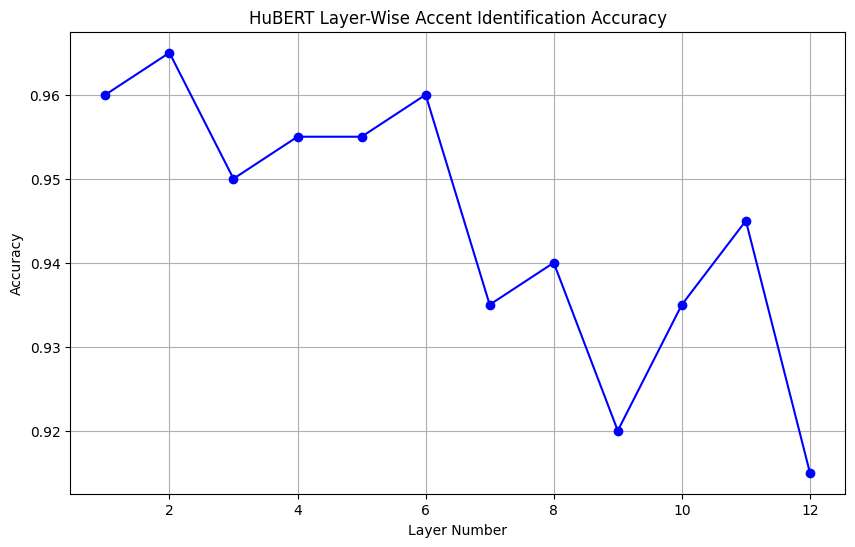

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
from transformers import Wav2Vec2FeatureExtractor, HubertModel
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import librosa
import warnings

# --- SETUP ---
device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_ID = "facebook/hubert-base-ls960"

print("1. Loading Data...")
dataset = load_dataset("DarshanaS/IndicAccentDb", split="train", streaming=False)

# --- FIX: SHUFFLE BEFORE SELECTING ---
# We shuffle first so the 1000 samples contain ALL languages, not just the first one.
dataset = dataset.shuffle(seed=42).select(range(1000))

print(f"Using subset of {len(dataset)} mixed samples.")

processor = Wav2Vec2FeatureExtractor.from_pretrained(MODEL_ID)
model = HubertModel.from_pretrained(MODEL_ID).to(device)

# --- EXTRACTION FUNCTION (ALL LAYERS) ---
def extract_all_layers(batch):
    audio_arrays = [x["array"] for x in batch["audio"]]
    inputs = processor(audio_arrays, sampling_rate=16000, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        # output_hidden_states=True gives us all 12 layers
        outputs = model(**inputs, output_hidden_states=True)

    # Stack all 12 layers: (13, batch, seq, hidden) -> We ignore layer 0 (embeddings)
    hidden_states = outputs.hidden_states[1:]

    # Mean pool each layer
    layer_features = []
    for layer_tensor in hidden_states:
        # Mean across time dimension
        pooled = torch.mean(layer_tensor, dim=1).cpu().numpy()
        layer_features.append(pooled)

    # Store as a list of numpy arrays
    batch["layer_features"] = np.stack(layer_features, axis=1) # Shape: (batch, 12, 768)
    return batch

# --- RUN PIPELINE ---
print("2. Resampling and Extracting All Layers...")
def resample(ex):
    if ex["audio"]["sampling_rate"] != 16000:
        ex["audio"]["array"] = librosa.resample(ex["audio"]["array"], orig_sr=ex["audio"]["sampling_rate"], target_sr=16000)
    return ex

# Map functions
ds = dataset.map(resample)
# Increase batch size slightly for speed since we use fewer samples
ds = ds.map(extract_all_layers, batched=True, batch_size=4)

# --- TRAIN 12 SVMs ---
all_accuracies = []
X_stack = np.array(ds["layer_features"]) # Shape: (1000, 12, 768)
y = np.array(ds["label"])

print("\n3. Training 12 classifiers (one per layer)...")
for i in range(12):
    X_layer = X_stack[:, i, :] # Get features for Layer i+1

    # Check if we have enough classes (Just in case)
    if len(np.unique(y)) < 2:
        print("Error: Still only 1 class found. Dataset shuffle failed.")
        break

    X_train, X_test, y_train, y_test = train_test_split(X_layer, y, test_size=0.2, random_state=42, stratify=y)

    scaler = StandardScaler().fit(X_train)
    clf = SVC(max_iter=1000)
    clf.fit(scaler.transform(X_train), y_train)

    acc = accuracy_score(y_test, clf.predict(scaler.transform(X_test)))
    all_accuracies.append(acc)
    print(f"Layer {i+1}: {acc*100:.1f}%")

# --- PLOT GRAPH ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, 13), all_accuracies, marker='o', linestyle='-', color='b')
plt.title("HuBERT Layer-Wise Accent Identification Accuracy")
plt.xlabel("Layer Number")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()